In [1]:
 #@title Import all necessary libraries

import torch, torch.nn as nn, torch.optim as optim, torchaudio, torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import glob, os, random, zipfile, requests, re, traceback, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from io import BytesIO

In [2]:

print("--- Starting Final Training: Building the High-Accuracy Expert Model ---")
device = "cuda" if torch.cuda.is_available() else "cpu"

--- Starting Final Training: Building the High-Accuracy Expert Model ---


In [3]:
# --- Step 2: AGGRESSIVE CLEANUP of old data ---
!rm -rf fsdd_data master.zip
print("Cleanup complete.")

Cleanup complete.


In [4]:
# --- Step 3: Download and Unpack FSDD Data ---
print("Downloading and unpacking FSDD data...")
FSDD_URL = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
response_fsdd = requests.get(FSDD_URL, stream=True); response_fsdd.raise_for_status()
with zipfile.ZipFile(BytesIO(response_fsdd.content)) as z: z.extractall("fsdd_data")
FSDD_RECS_PATTERN = os.path.join("fsdd_data", "*", "recordings")
found_fsdd_dirs = glob.glob(FSDD_RECS_PATTERN)
if not found_fsdd_dirs: raise FileNotFoundError("Could not find FSDD 'recordings' directory.")
FSDD_DATA_DIR = found_fsdd_dirs[0]
print(f"✅ FSDD data is ready.")

✅ FSDD data is ready.


In [5]:
# --- Step 4: Prepare FSDD File Paths and Labels ---
wav_files = glob.glob(os.path.join(FSDD_DATA_DIR, "*.wav"))
file_paths, labels = [], []
for file_path in wav_files:
    match = re.search(r'(\d+)_', os.path.basename(file_path))
    if match: file_paths.append(file_path); labels.append(int(match.group(1)))
print(f"Found {len(file_paths)} audio files.")

Found 3000 audio files.


--- 1. Class Distribution Analysis ---
Number of samples per digit:
0    300
1    300
2    300
3    300
4    300
5    300
6    300
7    300
8    300
9    300
Name: count, dtype: int64


/tmp/ipython-input-2941584510.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


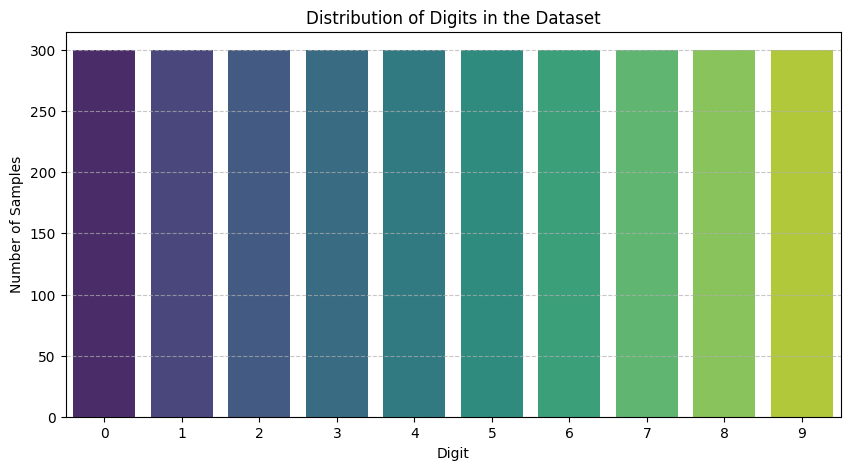


--- 2. Audio Duration Analysis ---
Minimum duration: 0.14 seconds
Maximum duration: 2.28 seconds
Average duration: 0.44 seconds

--- 3. Glimpse at Audio Samples ---
Displaying sample for digit '5': 5_george_20.wav


Displaying sample for digit '4': 4_george_43.wav


Displaying sample for digit '8': 8_jackson_25.wav


Displaying sample for digit '7': 7_lucas_13.wav


Displaying sample for digit '3': 3_lucas_28.wav


In [6]:
#@title Data Exploration (Corrected)

import pandas as pd
import librosa
from IPython.display import display, Audio # <--- THIS IS THE FIX

# --- 1. Explore Class Balance ---
# We already have the 'labels' list from the previous cell
print("--- 1. Class Distribution Analysis ---")
label_counts = pd.Series(labels).value_counts().sort_index()

print("Number of samples per digit:")
print(label_counts)

# Visualize the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Digits in the Dataset")
plt.xlabel("Digit")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 2. Explore Audio Durations ---
# We will analyze the original 8kHz files for this
print("\n--- 2. Audio Duration Analysis ---")
durations = []
for file_path in file_paths:
    # librosa.get_duration is a convenient way to get the length in seconds
    duration = librosa.get_duration(path=file_path)
    durations.append(duration)

min_duration = min(durations)
max_duration = max(durations)
avg_duration = sum(durations) / len(durations)

print(f"Minimum duration: {min_duration:.2f} seconds")
print(f"Maximum duration: {max_duration:.2f} seconds")
print(f"Average duration: {avg_duration:.2f} seconds")

# --- 3. Glimpse at Audio Samples ---
print("\n--- 3. Glimpse at Audio Samples ---")
# Randomly select 5 files to listen to
random_sample_paths = random.sample(file_paths, 5)

for path in random_sample_paths:
    # Extract the label from the filename again for display
    label_match = re.search(r'(\d+)_', os.path.basename(path))
    if label_match:
        digit_label = label_match.group(1)
        print(f"Displaying sample for digit '{digit_label}': {os.path.basename(path)}")
        # Display the IPython audio player
        display(Audio(path))

In [7]:
#@title Datasets and DataLoaders
class SpokenDigitDatasetClean(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
        self.target_sample_rate = 48000
        self.target_length_samples = self.target_sample_rate * 1
        self.resampler = T.Resample(orig_freq=8000, new_freq=self.target_sample_rate)
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=2048, hop_length=512, n_mels=128
        )
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform_8k, _ = torchaudio.load(file_path)
        waveform_48k = self.resampler(waveform_8k)
        if waveform_48k.shape[0] > 1: waveform_48k = torch.mean(waveform_48k, dim=0, keepdim=True)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if waveform_48k.shape[1] < self.target_length_samples:
            waveform_48k = torch.nn.functional.pad(waveform_48k, (0, self.target_length_samples - waveform_48k.shape[1]))
        else:
            waveform_48k = waveform_48k[:, :self.target_length_samples]
        spec = self.mel_spectrogram(waveform_48k)
        log_spec = torch.log(torch.clamp(spec, min=1e-6))
        return log_spec.squeeze(0).unsqueeze(0), label

# --- Step 6: Create Datasets and DataLoaders ---
train_size = int(0.8 * len(file_paths)); val_size = int(0.1 * len(file_paths))
test_size = len(file_paths) - train_size - val_size
train_dataset = SpokenDigitDatasetClean(file_paths[:train_size], labels[:train_size])
val_dataset = SpokenDigitDatasetClean(file_paths[train_size:train_size+val_size], labels[train_size:train_size+val_size])
test_dataset = SpokenDigitDatasetClean(file_paths[train_size+val_size:], labels[train_size+val_size:])

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
for specs, labels in train_loader:
    input_shape_for_model = specs.shape[1:]
    break
print(f"✅ Final input shape (C, H, W): {input_shape_for_model}")


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

✅ Final input shape (C, H, W): torch.Size([1, 128, 94])


In [8]:
# to solve the "air gap" problem with a live microphone.
# The Domain Mismatch Problem: this mismatch is so severe that the model fails completely. so we have to resample the data to microphones record at a much higher, high-fidelity sample rate, almost always 48000 Hz (or sometimes 44100 Hz).


# to solve the "mono and stereo" channels.
# The Risk: The FSDD dataset is known to contain only mono files. However, we cannot guarantee this. A single stereo file accidentally included in the dataset would cause the entire training process to crash with a tensor shape error as soon as the DataLoader tried to batch it.
# The Solution: Enforce Consistency. check if the audio has more than one channel. If it does (e.g., it's stereo), it takes the average of the channels to convert it into a mono signal with the correct shape


In [9]:
#@title Model Architecture
class DigitRecognizerCNN(nn.Module):
    def __init__(self, input_shape):
        super(DigitRecognizerCNN, self).__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv_block_3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv_block_3(self.conv_block_2(self.conv_block_1(dummy_input)))
            flattened_size = dummy_output.flatten(1).shape[1]
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(flattened_size, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 10))
    def forward(self, x):
        x = self.conv_block_1(x); x = self.conv_block_2(x); x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

model = DigitRecognizerCNN(input_shape_for_model).to(device)

In [10]:
#@title The Training Loop

# --- Set Random Seeds for Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Step 8: The Training Loop ---
# without applying label smoothing just to see the loss function #factor = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
EPOCHS = 40
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)
best_val_accuracy = 0

print("\n--- Starting Final Model Training ---")
for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        scheduler.step()

        # --- TRACK LOSS AND ACCURACY ---
        train_loss += loss.item() * inputs.size(0) # Accumulate weighted loss
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0); train_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / train_total
    avg_train_acc = train_correct / train_total

    # --- Validation Phase ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # --- TRACK LOSS AND ACCURACY ---
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0); val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / val_total
    avg_val_acc = val_correct / val_total

    # --- Logging and Checkpointing ---
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    if avg_val_acc > best_val_accuracy:
        best_val_accuracy = avg_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ New best model saved with Val Acc: {best_val_accuracy:.4f}")

print(f"\n✅ Training complete. Best validation accuracy: {best_val_accuracy:.4f}")


--- Starting Final Model Training ---


Epoch 1/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Epoch 1/40 -> Train Loss: 2.2708, Train Acc: 0.2483 | Val Loss: 1.5452, Val Acc: 0.5333
✅ New best model saved with Val Acc: 0.5333


Epoch 2/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/40 -> Train Loss: 1.1691, Train Acc: 0.6104 | Val Loss: 0.5715, Val Acc: 0.8833
✅ New best model saved with Val Acc: 0.8833


Epoch 3/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/40 -> Train Loss: 0.6012, Train Acc: 0.7917 | Val Loss: 0.2249, Val Acc: 0.9400
✅ New best model saved with Val Acc: 0.9400


Epoch 4/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/40 -> Train Loss: 0.5341, Train Acc: 0.8008 | Val Loss: 0.4181, Val Acc: 0.8400


Epoch 5/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/40 -> Train Loss: 0.6216, Train Acc: 0.7638 | Val Loss: 0.2688, Val Acc: 0.9267


Epoch 6/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/40 -> Train Loss: 0.5772, Train Acc: 0.8008 | Val Loss: 0.4773, Val Acc: 0.7967


Epoch 7/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/40 -> Train Loss: 0.5007, Train Acc: 0.8221 | Val Loss: 0.4488, Val Acc: 0.8567


Epoch 8/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/40 -> Train Loss: 0.4135, Train Acc: 0.8550 | Val Loss: 0.2809, Val Acc: 0.9133


Epoch 9/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/40 -> Train Loss: 0.3414, Train Acc: 0.8954 | Val Loss: 0.3805, Val Acc: 0.8867


Epoch 10/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/40 -> Train Loss: 0.3450, Train Acc: 0.8879 | Val Loss: 0.5099, Val Acc: 0.8267


Epoch 11/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/40 -> Train Loss: 0.2845, Train Acc: 0.8996 | Val Loss: 0.8692, Val Acc: 0.7533


Epoch 12/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/40 -> Train Loss: 0.3620, Train Acc: 0.8767 | Val Loss: 0.1402, Val Acc: 0.9533
✅ New best model saved with Val Acc: 0.9533


Epoch 13/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/40 -> Train Loss: 0.2144, Train Acc: 0.9196 | Val Loss: 0.0766, Val Acc: 0.9767
✅ New best model saved with Val Acc: 0.9767


Epoch 14/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14/40 -> Train Loss: 0.1977, Train Acc: 0.9308 | Val Loss: 0.1044, Val Acc: 0.9833
✅ New best model saved with Val Acc: 0.9833


Epoch 15/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 15/40 -> Train Loss: 0.1478, Train Acc: 0.9433 | Val Loss: 0.0909, Val Acc: 0.9767


Epoch 16/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 16/40 -> Train Loss: 0.1455, Train Acc: 0.9471 | Val Loss: 0.1588, Val Acc: 0.9633


Epoch 17/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 17/40 -> Train Loss: 0.1357, Train Acc: 0.9492 | Val Loss: 0.0652, Val Acc: 0.9767


Epoch 18/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 18/40 -> Train Loss: 0.1222, Train Acc: 0.9533 | Val Loss: 0.0847, Val Acc: 0.9833


Epoch 19/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 19/40 -> Train Loss: 0.1560, Train Acc: 0.9533 | Val Loss: 0.0320, Val Acc: 0.9867
✅ New best model saved with Val Acc: 0.9867


Epoch 20/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 20/40 -> Train Loss: 0.1109, Train Acc: 0.9629 | Val Loss: 0.0355, Val Acc: 0.9867


Epoch 21/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 21/40 -> Train Loss: 0.0877, Train Acc: 0.9708 | Val Loss: 0.0363, Val Acc: 0.9933
✅ New best model saved with Val Acc: 0.9933


Epoch 22/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 22/40 -> Train Loss: 0.0863, Train Acc: 0.9688 | Val Loss: 0.0407, Val Acc: 0.9900


Epoch 23/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 23/40 -> Train Loss: 0.0667, Train Acc: 0.9742 | Val Loss: 0.0455, Val Acc: 0.9833


Epoch 24/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 24/40 -> Train Loss: 0.0566, Train Acc: 0.9792 | Val Loss: 0.0371, Val Acc: 0.9933


Epoch 25/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 25/40 -> Train Loss: 0.0421, Train Acc: 0.9829 | Val Loss: 0.0235, Val Acc: 0.9933


Epoch 26/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 26/40 -> Train Loss: 0.0512, Train Acc: 0.9825 | Val Loss: 0.0187, Val Acc: 0.9900


Epoch 27/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 27/40 -> Train Loss: 0.0344, Train Acc: 0.9867 | Val Loss: 0.0200, Val Acc: 0.9933


Epoch 28/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 28/40 -> Train Loss: 0.0455, Train Acc: 0.9800 | Val Loss: 0.0335, Val Acc: 0.9900


Epoch 29/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 29/40 -> Train Loss: 0.0376, Train Acc: 0.9867 | Val Loss: 0.0180, Val Acc: 0.9967
✅ New best model saved with Val Acc: 0.9967


Epoch 30/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 30/40 -> Train Loss: 0.0233, Train Acc: 0.9904 | Val Loss: 0.0271, Val Acc: 0.9967


Epoch 31/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 31/40 -> Train Loss: 0.0287, Train Acc: 0.9875 | Val Loss: 0.0303, Val Acc: 0.9933


Epoch 32/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 32/40 -> Train Loss: 0.0329, Train Acc: 0.9875 | Val Loss: 0.0312, Val Acc: 0.9933


Epoch 33/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 33/40 -> Train Loss: 0.0282, Train Acc: 0.9879 | Val Loss: 0.0231, Val Acc: 0.9967


Epoch 34/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 34/40 -> Train Loss: 0.0284, Train Acc: 0.9925 | Val Loss: 0.0172, Val Acc: 0.9933


Epoch 35/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 35/40 -> Train Loss: 0.0247, Train Acc: 0.9900 | Val Loss: 0.0216, Val Acc: 0.9967


Epoch 36/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 36/40 -> Train Loss: 0.0220, Train Acc: 0.9921 | Val Loss: 0.0194, Val Acc: 0.9967


Epoch 37/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 37/40 -> Train Loss: 0.0209, Train Acc: 0.9929 | Val Loss: 0.0234, Val Acc: 0.9967


Epoch 38/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 38/40 -> Train Loss: 0.0274, Train Acc: 0.9875 | Val Loss: 0.0240, Val Acc: 0.9967


Epoch 39/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 39/40 -> Train Loss: 0.0207, Train Acc: 0.9921 | Val Loss: 0.0238, Val Acc: 0.9967


Epoch 40/40 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 40/40 -> Train Loss: 0.0162, Train Acc: 0.9950 | Val Loss: 0.0253, Val Acc: 0.9967

✅ Training complete. Best validation accuracy: 0.9967



--- Final Evaluation on Test Set ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

✅ Final Test Accuracy: 0.9933 (99.33%)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       0.96      1.00      0.98        26
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        37
           5       1.00      1.00      1.00        33
           6       1.00      0.97      0.98        31
           7       1.00      0.97      0.98        30
           8       0.96      1.00      0.98        26
           9       1.00      1.00      1.00        34

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



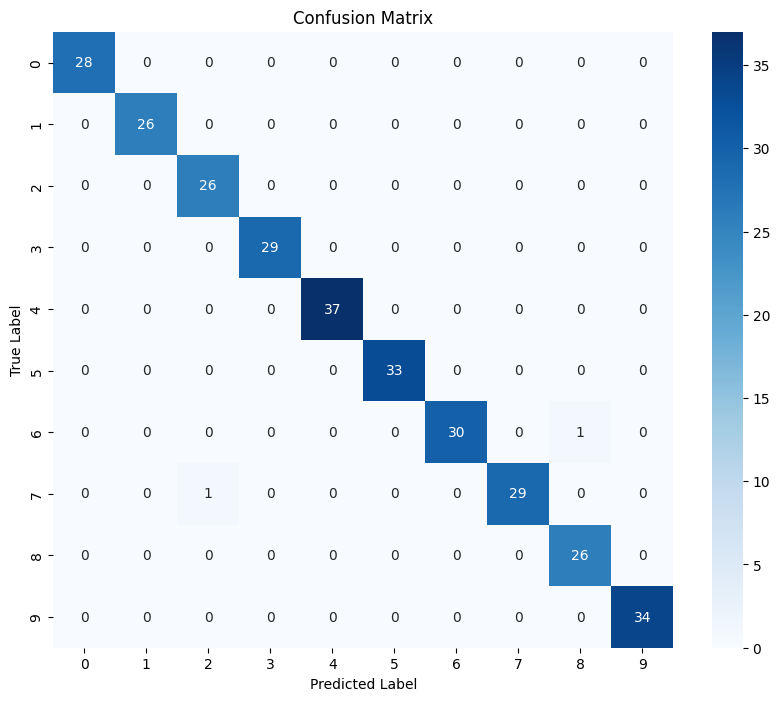

In [12]:
# --- Step 10: Final Evaluation (with Probability Storage for Calibration) ---
from sklearn.metrics import accuracy_score # Import the accuracy_score function

print("\n--- Final Evaluation on Test Set ---")
model.load_state_dict(torch.load('best_model.pth'))
y_true, y_pred, y_pred_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))

        # Get raw probabilities from the softmax output
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get the top probability and the predicted class
        top_probs, predicted_classes = torch.max(probabilities, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes.cpu().numpy())
        # Store the confidence score (the probability of the predicted class)
        y_pred_probs.extend(top_probs.cpu().numpy())

# --- NEW: Calculate and print the test accuracy ---
test_accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy:.2%})")
# ----------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Plot the Confusion Matrix (code is unchanged)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

## Calibration Analysis


In [14]:
#@title FINAL EXPERIMENT: Step 1 - Determine Scaling Temperature

import torch.optim as optim

print("--- FINAL EXPERIMENT: Starting Step 1: Finding the Optimal Temperature ---")

# --- Load the best model from the most recent training run ---
print("Loading the 'best_model.pth'...")
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

# --- Extract all logits from the validation set ---
print("Extracting logits from the validation set...")
all_val_logits = []
all_val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        all_val_logits.append(logits)
        all_val_labels.append(labels)

all_val_logits = torch.cat(all_val_logits)
all_val_labels = torch.cat(all_val_labels)

# --- Optimize for the best temperature using the re-parameterization method ---
print("Optimizing for the temperature parameter...")
nll_criterion = nn.CrossEntropyLoss()

# We optimize log(T) to ensure T is always positive. Initialize T to start at 1.5.
log_temp_param = nn.Parameter(torch.ones(1).to(device) * 0.4)
optimizer = optim.Adam([log_temp_param], lr=0.01)

# Optimization loop
for i in range(100):
    optimizer.zero_grad()
    temperature_val = torch.exp(log_temp_param)
    loss = nll_criterion(all_val_logits / temperature_val, all_val_labels)
    loss.backward()
    optimizer.step()

# Store the final value in a new, distinct variable
final_optimal_temperature = torch.exp(log_temp_param).item()
print(f"✅ FINAL EXPERIMENT Step 1 Complete. Optimal Temperature: {final_optimal_temperature:.4f}")

--- FINAL EXPERIMENT: Starting Step 1: Finding the Optimal Temperature ---
Loading the 'best_model.pth'...
Extracting logits from the validation set...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Optimizing for the temperature parameter...
✅ FINAL EXPERIMENT Step 1 Complete. Optimal Temperature: 1.0973


In [15]:
#@title FINAL EXPERIMENT: Step 2 - Generate Final Predictions

# This cell uses 'model' and 'final_optimal_temperature' from the previous cell.
model.eval()

# --- Create new, distinct variables to store the final results ---
final_calibrated_probs = []
final_true_labels = []

print("\n--- FINAL EXPERIMENT: Starting Step 2: Generating calibrated predictions for the test set... ---")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # Get raw logits
        logits = model(inputs)

        # Apply the final optimal temperature
        scaled_logits = logits / final_optimal_temperature

        # Calculate calibrated probabilities
        probabilities = torch.nn.functional.softmax(scaled_logits, dim=1)

        # Store results in our new variables
        final_calibrated_probs.append(probabilities.cpu())
        final_true_labels.append(labels.cpu())

# Concatenate all batch results into single tensors
final_calibrated_probs = torch.cat(final_calibrated_probs)
final_true_labels = torch.cat(final_true_labels)

print("✅ FINAL EXPERIMENT Step 2 Complete. New prediction variables are ready.")


--- FINAL EXPERIMENT: Starting Step 2: Generating calibrated predictions for the test set... ---
✅ FINAL EXPERIMENT Step 2 Complete. New prediction variables are ready.



--- FINAL EXPERIMENT: Starting Step 3: Plotting the final results... ---


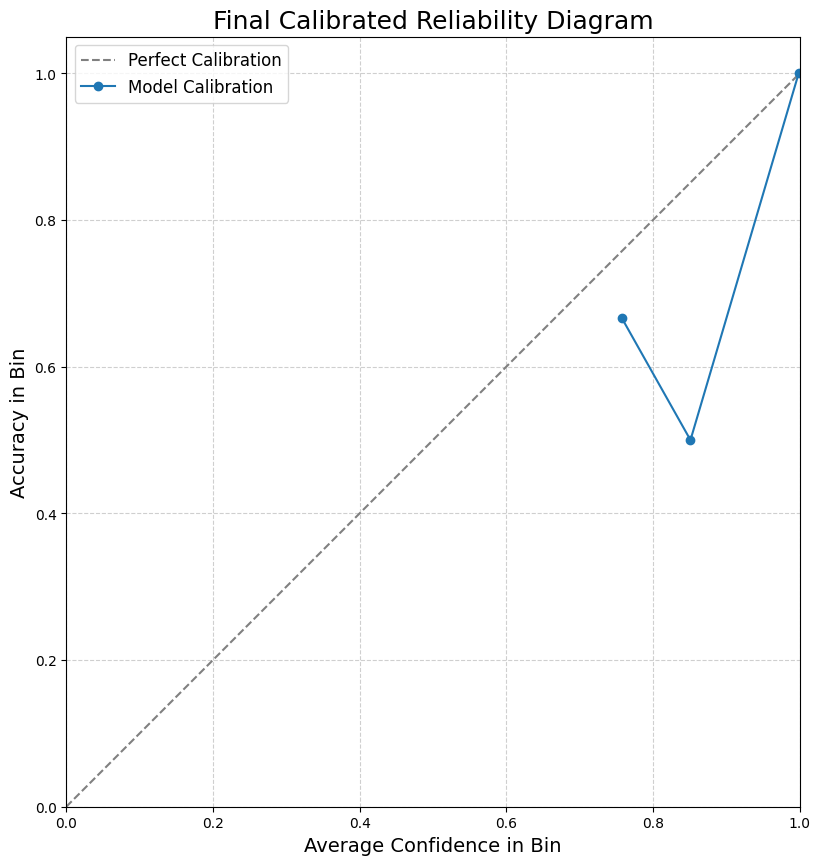

In [16]:
#@title FINAL EXPERIMENT: Step 3 - Plot Final Reliability Diagram

import numpy as np
import matplotlib.pyplot as plt

def generate_final_plot(true_labels, pred_probs, n_bins=10):
    """
    Plots the final reliability diagram.
    """
    true_labels_np = true_labels.numpy()
    pred_probs_np = pred_probs.numpy()

    confidences = np.max(pred_probs_np, axis=1)
    predicted_labels = np.argmax(pred_probs_np, axis=1)
    is_correct = (predicted_labels == true_labels_np)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    bin_accuracies = []
    bin_confidences = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin_mask = (confidences > bin_lower) & (confidences <= bin_upper)
        if np.sum(in_bin_mask) > 0:
            accuracy_in_bin = np.mean(is_correct[in_bin_mask])
            confidence_in_bin = np.mean(confidences[in_bin_mask])
            bin_accuracies.append(accuracy_in_bin)
            bin_confidences.append(confidence_in_bin)

    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.plot(bin_confidences, bin_accuracies, marker='o', linestyle='-', label='Model Calibration')
    plt.xlabel('Average Confidence in Bin', fontsize=14)
    plt.ylabel('Accuracy in Bin', fontsize=14)
    plt.title('Final Calibrated Reliability Diagram', fontsize=18)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# --- Call the function with the new, distinct variables from this experiment ---
print("\n--- FINAL EXPERIMENT: Starting Step 3: Plotting the final results... ---")
generate_final_plot(final_true_labels, final_calibrated_probs)